In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.distributions as tdist
import numpy as np
import matplotlib.pyplot as plt


# Set seed
torch.manual_seed(0)

# Where to add a new import
from torch.optim.lr_scheduler import StepLR

In [5]:
n_iters = 1000
n_sub_iters = 10
batch_size = 1 
num_atoms = 10

In [6]:
normal_dist = tdist.MultivariateNormal(torch.tensor([0.,0.]), torch.tensor([[1.,.5],[.5,1.]]))

In [16]:
def l2_cost(x,y):
    return torch.sqrt(torch.sum((x-y)**2, axis=1))

In [17]:
def er_chi_unnorm(x,yj,gj, epsilon, cost_func=l2_cost):
    return torch.exp((-cost_func(x,yj)+gj)/epsilon)

In [25]:
def er_chi(x, y, g, epsilon, cost_func=l2_cost):
    chis = er_chi_unnorm(x,y,g,epsilon, cost_func)
    return chis/ torch.sum(chis)

In [20]:
# entropic reg c-transform
def er_ctran(x, g, y, epsilon, cost_func):
    return -epsilon * torch.log(torch.sum(torch.exp((-cost_func(x,y)+g)/epsilon)/torch.tensor(num_atoms))) + torch.sum(g)/torch.tensor(num_atoms)

In [10]:
# init vectors
y = torch.tensor(np.random.random(size=(num_atoms,2)), requires_grad = False)
g = torch.tensor(np.random.random(size=num_atoms), requires_grad = True)
b = torch.ones(num_atoms)/ torch.tensor(num_atoms)
epsilon = torch.tensor(2.)

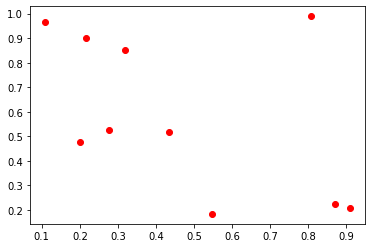

In [11]:
ys = y.detach().numpy()
plt.plot(ys[:,0],ys[:,1], 'ro')

In [12]:
def plot_tensor(tensor):
    ys = tensor.detach().numpy()
    plt.plot(ys[:,0],ys[:,1], 'ro')

array([[0.08871112],
       [0.10723135],
       [0.12600297],
       [0.10065057],
       [0.09396664],
       [0.09656142],
       [0.08145145],
       [0.12800508],
       [0.08115129],
       [0.09626809]])

In [22]:
y

tensor([[0.1092, 0.9650],
        [0.8714, 0.2255],
        [0.2152, 0.9004],
        [0.5478, 0.1835],
        [0.4353, 0.5188],
        [0.9090, 0.2067],
        [0.2014, 0.4763],
        [0.8075, 0.9893],
        [0.2772, 0.5237],
        [0.3190, 0.8534]], dtype=torch.float64)

In [21]:
y

tensor([[0.1092, 0.9650],
        [0.8714, 0.2255],
        [0.2152, 0.9004],
        [0.5478, 0.1835],
        [0.4353, 0.5188],
        [0.9090, 0.2067],
        [0.2014, 0.4763],
        [0.8075, 0.9893],
        [0.2772, 0.5237],
        [0.3190, 0.8534]], dtype=torch.float64)

## INSTANTIATE OPTIMIZER CLASS

In [40]:
x = normal_dist.sample()
chis = [er_chi_j(x, y, g, epsilon, i).detach().numpy() for i in range(10)]

In [46]:
torch.exp((-l2_cost(x,y)+g)/epsilon)

tensor([[0.0509],
        [0.0509],
        [0.0509],
        [0.0509],
        [0.0509],
        [0.0509],
        [0.0509],
        [0.0509],
        [0.0509],
        [0.0509]], dtype=torch.float64, grad_fn=<ExpBackward>)

In [50]:
l2_cost(x, y[1])

tensor(1.9032, dtype=torch.float64)

In [54]:
l2_cost(x, y[0])

tensor(2.2824, dtype=torch.float64)

tensor([0.1018, 0.0912, 0.1062, 0.0850, 0.1002, 0.0906, 0.0891, 0.1304, 0.0943,
        0.1113], dtype=torch.float64, grad_fn=<DivBackward0>)

tensor([0.6423, 0.8996])

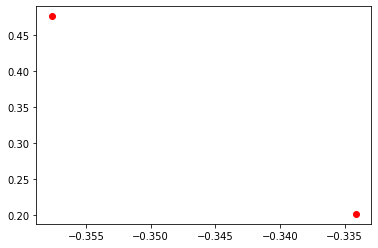

In [39]:
x = normal_dist.sample()
plt.plot(x.detach().numpy(), y[torch.argmax(er_chi(x, y, g, epsilon))].detach().numpy(), 'ro')


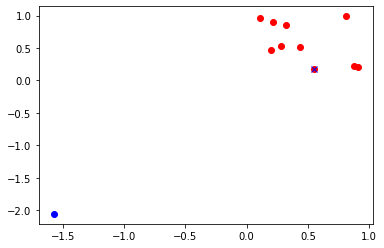

In [68]:
ys = y.detach().numpy()
plt.plot(ys[:,0],ys[:,1], 'ro')
x = normal_dist.sample()
y_plot = y[torch.argmax(er_chi(x, y, g, epsilon))].detach().numpy()

x = x.numpy()
plt.plot(x[0],x[1],'bo')
plt.plot(y_plot[0],y_plot[1],'bx')

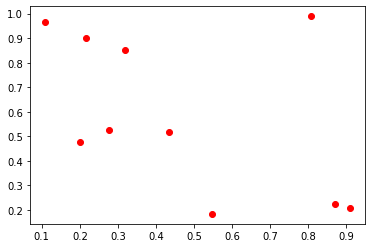

In [60]:
plt.plot(ys[:,0],ys[:,1], 'ro')

In [59]:
y_plot

array([0.20143096, 0.47632823])

tensor([-0.8482, -0.4719])

## INSTANTIATE STEP LEARNING SCHEDULER CLASS

In [12]:
learning_rate = 0.1
optimizer_atoms = torch.optim.SGD([y], lr=learning_rate, momentum=0.9, nesterov=True)
optimizer_map = torch.optim.SGD([g], lr=learning_rate, momentum=0.9, nesterov=True)

# step_size: at how many multiples of epoch you decay
# new_lr = lr*gamma 

# gamma = decaying factor
scheduler_atoms = StepLR(optimizer_atoms, step_size=1, gamma=0.8)
scheduler_map = StepLR(optimizer_map, step_size=1, gamma=0.8)



In [13]:
for i in range(n_iters):
    x = normal_dist.sample()

    # Clear gradients w.r.t. parameters
    optimizer_map.zero_grad()

    # Get dual objective to maximise
    dual_objective = er_ctran(x, g, y, epsilon, l2_cost)
    map_loss = -dual_objective

    # Getting gradients w.r.t. parameters
    map_loss.backward()
    optimizer_map.step()
    
    # Updating parameters
    if i % 100 == 0:
        print(g)
        scheduler_map.step()
        print(map_loss)
        

tensor([0.5755, 0.4970, 0.3159, 0.6193, 0.1856, 0.2306, 0.5299, 0.5117, 0.0843,
        0.5002], dtype=torch.float64, requires_grad=True)
tensor(-1.0973, dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.4311, 0.4620, 0.4211, 0.3099, 0.3372, 0.4821, 0.2670, 0.6211, 0.2980,
        0.4206], dtype=torch.float64, requires_grad=True)
tensor(-1.3762, dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.4528, 0.4427, 0.4314, 0.3139, 0.3410, 0.4587, 0.2815, 0.5941, 0.3084,
        0.4257], dtype=torch.float64, requires_grad=True)
tensor(-1.1705, dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.4529, 0.4461, 0.4323, 0.3047, 0.3381, 0.4608, 0.2592, 0.6327, 0.2934,
        0.4298], dtype=torch.float64, requires_grad=True)
tensor(-2.3651, dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.4528, 0.4392, 0.4328, 0.3142, 0.3471, 0.4531, 0.2836, 0.5863, 0.3122,
        0.4287], dtype=torch.float64, requires_grad=True)
tensor(-0.6908, dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.

## TRAIN MODEL

### Min Max Optimization

In [15]:
for i in range(n_iters):
    for _ in range(n_sub_iters):
        # sample x
        x = normal_dist.sample()

        # Clear gradients w.r.t. parameters
        optimizer_map.zero_grad()
        
        # Get dual objective to maximise
        dual_objective = er_ctran(x, g, y, epsilon, l2_cost)
        map_loss = -dual_objective
        
        # Getting gradients w.r.t. parameters
        map_loss.backward()

        # Updating parameters
        optimizer_map.step()
        
    for _ in range(n_sub_iters):
        # sample x
        x = normal_dist.sample()

        # Clear gradients w.r.t. parameters
        optimizer_atoms.zero_grad()
        
        # Get loss objective to minimise
        atoms_loss = er_ctran(x, g, y, epsilon, l2_cost)
        
        # Getting gradients w.r.t. parameters
        atoms_loss.backward()

        # Updating parameters
        optimizer_atoms.step()
    
    # Updating parameters
    if i % 100 == 0:
        print(g)
        print(map_loss)
        # Decay Learning Rate
        scheduler_atoms.step()
        scheduler_map.step()
    
    print("Loss: {0}".format(map_loss))

tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=torch.float64, requires_grad=True)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan

Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=torch.float64, requires_grad=True)
tensor(nan, dtype=torch.float64, grad_fn=<NegBackward>)
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan

In [16]:
g

tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=torch.float64, requires_grad=True)

In [17]:
y

tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=torch.float64, requires_grad=True)